# Political Bias Classification with Simple Neural Networks

##### Importing Libraries and Loading data

In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_colwidth', -1)

/Users/feihuyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [18]:
df1 = pd.read_csv('/Users/feihuyan/Downloads/news/articles1.csv')
df2 = pd.read_csv('/Users/feihuyan/Downloads/news/articles2.csv')
df3 = pd.read_csv('/Users/feihuyan/Downloads/news/articles3.csv')

In [158]:
df = pd.concat([df1, df2, df3])

In [159]:
set(df['publication'])

{'Atlantic',
 'Breitbart',
 'Business Insider',
 'Buzzfeed News',
 'CNN',
 'Fox News',
 'Guardian',
 'NPR',
 'National Review',
 'New York Post',
 'New York Times',
 'Reuters',
 'Talking Points Memo',
 'Vox',
 'Washington Post'}

In [160]:
bias = { 'Atlantic': 2,
         'Breitbart': 1,
         'Business Insider': 2,
         'Buzzfeed News': 2,
         'CNN': 0,
         'Fox News': 1,
         'Guardian': 2,
         'NPR': 2,
         'National Review': 2,
         'New York Post': 2,
         'New York Times': 0,
         'Reuters': 2,
         'Talking Points Memo': 2,
         'Vox': 2,
         'Washington Post': 2}
df['bias'] = df['publication'].map(bias)

In [26]:
bias = { 'Atlantic': 0,
         'Breitbart': 1,
         'Business Insider': 0,
         'Buzzfeed News': 0,
         'CNN': 0,
         'Fox News': 1,
         'Guardian': 0,
         'NPR': 0,
         'National Review': 1,
         'New York Post': 1,
         'New York Times': 0,
         'Reuters': 2,
         'Talking Points Memo': 0,
         'Vox': 0,
         'Washington Post': 0}
df['bias'] = df['publication'].map(bias)

In [161]:
left = df[df['bias'] == 0]
right = df[df['bias'] == 1]

### Passage to Sentence 

In [162]:
from nltk.tokenize import sent_tokenize

In [163]:
def passage_to_sentences(df, political_affiliation):
    l = []
    for row in tqdm(df):
        for sentence in sent_tokenize(row):
            l.append(sentence)
    result = pd.DataFrame({'text': l, 'target': political_affiliation})
    return result

In [164]:
left_sent = passage_to_sentences(left['content'], 0)

100%|██████████| 19291/19291 [00:37<00:00, 520.59it/s]


In [165]:
right_sent = passage_to_sentences(right['content'], 1)

100%|██████████| 28135/28135 [00:29<00:00, 956.39it/s] 


In [166]:
left_sent.head(5)

,text,target
0,WASHINGTON — Congressional Republicans have a new fear when it comes to their health care lawsuit against the Obama administration: They might win.,0
1,"The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for and Americans, handing House Republicans a big victory on issues.",0
2,"But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement.",0
3,That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government.,0
4,"To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been demanding an end to the law for years.",0


In [167]:
right_sent.head(5)

,text,target
0,"On Tuesday’s broadcast of CNN’s “Situation Room,” CNN Senior Washington Correspondent Jeff Zeleny stated that Chelsea Manning’s transition from a man to a woman “certainly played into” President Obama’s decision to commute Manning’s sentence, and “Without that, it’s hard to imagine, I think, this president would have done that.",1
1,"” Zeleny said, “I think a question that this president the White House will have to answer here — will answer, and I think it’s an important one, if — how much was the personal story of Chelsea Manning involved in this, because the outcry from the left was so strong on this.",1
2,"And she’s having a difficult time in federal prison, no question.",1
3,"But, to me, that is a central question here.",1
4,"Without that, you have to wonder if the outcome would be the same.",1


In [168]:
train_df = pd.concat([left_sent, right_sent])
train_df = train_df.sample(frac=1)
train_df.head(5)

,text,target
438349,"The day of the shooting, he’d posted a quote on Facebook from baseball great Jackie Robinson: ”A life is not important except in the impact it has on other lives.”",0
284486,They are also the segment of the population in Buffalo.,1
635652,"I knew Mike had access to a fun, fiery and somewhat sacred space in his community: a barbershop.",0
292898,"Contrary to what you might expect, it is very likely that last night’s scandalous resolution will accelerate this process, because it is the straw that broke the camel’s back.",1
245947,Republicans are on track to hold at least 240 seats in the House next year.,1


### Setting Up Embedding Matrix

In [169]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [170]:
max_features = 30000
maxlen = 25

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_df['text']))
X = tokenizer.texts_to_sequences(list(train_df['text']))
X = pad_sequences(X, maxlen = maxlen)
y = train_df['target']

In [171]:
embedding_size = 200
embedding_file = '/Users/feihuyan/Downloads/glove.twitter.27B.200d.txt'
embedding_index = {}
file = open(embedding_file)
for line in tqdm(file):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs

1193514it [00:53, 22492.31it/s]


In [172]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [173]:
print(X.shape)
print(y.shape)

(1498398, 25)
(1498398,)


In [174]:
embedding_matrix.shape

(30000, 200)

In [175]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.optimizers import adam

## Neural Network without Memory Feature, but with Embeddings

#### Using Average Pooling

In [472]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_size, weights=[embedding_matrix]),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
opt = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         6000000   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 200)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 24)                4824      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 25        
Total params: 6,004,849
Trainable params: 6,004,849
Non-trainable params: 0
_________________________________________________________________


In [473]:
batch_size = 100
epochs = 10
history = model.fit(X, 
                     y, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_split=0.2)

Epoch 1/10
11988/11988 [==============================] - 413s 34ms/step - loss: 0.5377 - accuracy: 0.7205 - val_loss: 0.5048 - val_accuracy: 0.7452
Epoch 2/10
11988/11988 [==============================] - 405s 34ms/step - loss: 0.4930 - accuracy: 0.7520 - val_loss: 0.4968 - val_accuracy: 0.7499
Epoch 3/10
11988/11988 [==============================] - 398s 33ms/step - loss: 0.4827 - accuracy: 0.7582 - val_loss: 0.4903 - val_accuracy: 0.7543
Epoch 4/10
11988/11988 [==============================] - 394s 33ms/step - loss: 0.4755 - accuracy: 0.7630 - val_loss: 0.4871 - val_accuracy: 0.7557
Epoch 5/10
11988/11988 [==============================] - 415s 35ms/step - loss: 0.4693 - accuracy: 0.7666 - val_loss: 0.4850 - val_accuracy: 0.7581
Epoch 6/10
11988/11988 [==============================] - 420s 35ms/step - loss: 0.4634 - accuracy: 0.7703 - val_loss: 0.4828 - val_accuracy: 0.7595
Epoch 7/10
11988/11988 [==============================] - 415s 35ms/step - loss: 0.4577 - accuracy: 0.7743

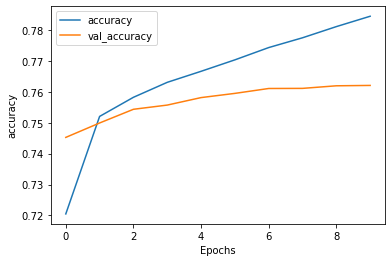

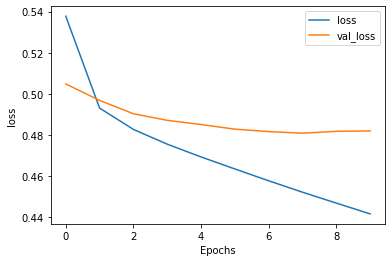

In [474]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [475]:
def test(text, true_class, passage=True, check=True):
    test_text = []
    if passage: 
        for sentence in sent_tokenize(text):
            test_text.append(sentence)
    else:
        test_text = [text]
        
    text_token = tokenizer.texts_to_sequences(test_text)
    text_pad = pad_sequences(text_token, maxlen = maxlen)
    pred_class = model.predict_classes(text_pad)
    pred_score = model.predict(text_pad)
    naive_loss = abs(true_class - pred_score)
    
    pol_class = 'right'
    content = 'sentence'
    success = 'succeeds'
 
    pred_score_passage = np.sum(pred_score)/int(len(text_pad))
    if passage:
        pred_class = 1
        if pred_score_passage < 0.5: pred_class, pol_class = 0, 'left'
        bias = float(abs(0.5-pred_score_passage)/0.5*100)
        content = 'passage'
        if check: 
            if pred_class != true_class: success = 'fails'
    else:
        if pred_score < 0.5: pol_class = 'left'
        bias = float(abs(0.5-pred_score)/0.5*100)
        if check: 
            if pred_class != true_class: success = 'fails'
    
    print('===========================================================================')
    print('Your answer:')
    print('------------')
    print(f'  - This {content} leans toward the {pol_class} in the political spectrum.')
    print(f'  - It is approximately {bias: .2f}% percent biased to the {pol_class}.')
    print(f'  - This model {success} in predicting the political bias.')
    print('===========================================================================')
    
    return pred_class, pred_score, naive_loss

### Test Case A: right-leaning sentences

##### A1).

In [476]:
fox_test1 = 'Top Republicans hit back at Pelosi for hypercharged language, calling GOP enemies of the state'

In [477]:
fox_test1

'Top Republicans hit back at Pelosi for hypercharged language, calling GOP enemies of the state'

In [478]:
test(fox_test1, 1, passage=False)

Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  63.17% percent biased to the right.
  - This model succeeds in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.81587255]], dtype=float32),
 array([[0.18412745]], dtype=float32))

##### A2).

In [479]:
fox_test2 = 'While the 2016 Republican convention was riddled with tension and protests over Donald Trump"s rise at the GOP nominee, four years later the gathering is dissent free as the four-day confab serves as a celebration of Trump – and a testament to the president"s complete takeover of the party.'

In [480]:
fox_test2

'While the 2016 Republican convention was riddled with tension and protests over Donald Trump"s rise at the GOP nominee, four years later the gathering is dissent free as the four-day confab serves as a celebration of Trump – and a testament to the president"s complete takeover of the party.'

In [481]:
test(fox_test2, 1, passage=False)

Your answer:
------------
  - This sentence leans toward the right in the political spectrum.
  - It is approximately  18.92% percent biased to the right.
  - This model succeeds in predicting the political bias.


(array([[1]], dtype=int32),
 array([[0.5945752]], dtype=float32),
 array([[0.40542477]], dtype=float32))

### Test Case B: left-leaning sentences

##### B1).

In [482]:
cnn_test = 'House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018.'

In [483]:
cnn_test

'House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018.'

In [484]:
test(cnn_test, 0, passage=False)

Your answer:
------------
  - This sentence leans toward the left in the political spectrum.
  - It is approximately  5.36% percent biased to the left.
  - This model succeeds in predicting the political bias.


(array([[0]], dtype=int32),
 array([[0.47319362]], dtype=float32),
 array([[0.47319362]], dtype=float32))

##### B2).

In [485]:
cnn_test2 = 'Evidence is growing that in November, the GOP could be pushed back further into its strongholds and lose more ground in diverse, growing metropolitan America, even if Trump finds a way to overcome his persistent deficits in national polls to Democratic nominee Joe Biden.'

In [486]:
cnn_test2

'Evidence is growing that in November, the GOP could be pushed back further into its strongholds and lose more ground in diverse, growing metropolitan America, even if Trump finds a way to overcome his persistent deficits in national polls to Democratic nominee Joe Biden.'

In [487]:
test(cnn_test2, 0, passage=False)

Your answer:
------------
  - This sentence leans toward the left in the political spectrum.
  - It is approximately  21.43% percent biased to the left.
  - This model succeeds in predicting the political bias.


(array([[0]], dtype=int32),
 array([[0.39284477]], dtype=float32),
 array([[0.39284477]], dtype=float32))

### Test Case C: right-leaning passages

##### C1).

In [488]:
fox_test_passage = 'The Journal article, which cites the International Monetary Fund, states that the pandemic and the resulting economic shutdowns have led to the expectation that global output will fall 5% this year, which is “far worse than during the [2008] financial crisis. It has also led to 400 million jobs lost worldwide, according to the International Labor Organization, with 13 million job losses in the U.S. alone.'

In [489]:
fox_test_passage

'The Journal article, which cites the International Monetary Fund, states that the pandemic and the resulting economic shutdowns have led to the expectation that global output will fall 5% this year, which is “far worse than during the [2008] financial crisis. It has also led to 400 million jobs lost worldwide, according to the International Labor Organization, with 13 million job losses in the U.S. alone.'

In [490]:
test(fox_test_passage, 1, passage=True)

Your answer:
------------
  - This passage leans toward the right in the political spectrum.
  - It is approximately  46.18% percent biased to the right.
  - This model succeeds in predicting the political bias.


(1,
 array([[0.6279074 ],
        [0.83387244]], dtype=float32),
 array([[0.3720926 ],
        [0.16612756]], dtype=float32))

##### C2).

In [491]:
fox_test_passage2 = 'On Tuesday, Israeli Defense Minister Benny Gantz had his first official talk with his UAE counterpart. The two discussed security cooperation between their countries and other regional issues. This, after Pompeo met Monday with Israeli Prime Minister Benjamin Netanyahu in Jerusalem and in a statement afterward slammed others for not supporting more pressure on Iranian leadership in Tehran. But to the backdrop of the election year, America’s top diplomat has been pressing hard to mend regional ties for Israel while isolating Iran. He was at the United Nations last week where he triggered a sanctions snapback on Iran for violations of the 2015 nuclear deal and continued provocative action in the Middle East.'

In [492]:
fox_test_passage2

'On Tuesday, Israeli Defense Minister Benny Gantz had his first official talk with his UAE counterpart. The two discussed security cooperation between their countries and other regional issues. This, after Pompeo met Monday with Israeli Prime Minister Benjamin Netanyahu in Jerusalem and in a statement afterward slammed others for not supporting more pressure on Iranian leadership in Tehran. But to the backdrop of the election year, America’s top diplomat has been pressing hard to mend regional ties for Israel while isolating Iran. He was at the United Nations last week where he triggered a sanctions snapback on Iran for violations of the 2015 nuclear deal and continued provocative action in the Middle East.'

In [493]:
test(fox_test_passage2, 1, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  12.65% percent biased to the left.
  - This model fails in predicting the political bias.


(0,
 array([[0.4070173 ],
        [0.3956162 ],
        [0.5780364 ],
        [0.27564016],
        [0.52736986]], dtype=float32),
 array([[0.5929827 ],
        [0.6043838 ],
        [0.42196357],
        [0.72435987],
        [0.47263014]], dtype=float32))

### Test Case D: left-leaning passages

##### D1).

In [494]:
cnn_test_passage = 'Compared with the 2016 GOP convention, which rippled with unresolved tension and resistance to Trump rise, the conspicuous absence of dissent at this years event underscores how the President has stamped the party with his trademark as surely as if it were one of his downtown skyscrapers. The party choice to skip passing a platform and instead approve a brief statement declaring it will enthusiastically support the Presidents America-first agenda testifies to his triumph.'           

In [495]:
cnn_test_passage

'Compared with the 2016 GOP convention, which rippled with unresolved tension and resistance to Trump rise, the conspicuous absence of dissent at this years event underscores how the President has stamped the party with his trademark as surely as if it were one of his downtown skyscrapers. The party choice to skip passing a platform and instead approve a brief statement declaring it will enthusiastically support the Presidents America-first agenda testifies to his triumph.'

In [496]:
test(cnn_test_passage, 0, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  89.27% percent biased to the left.
  - This model succeeds in predicting the political bias.


(0,
 array([[0.02623698],
        [0.08109915]], dtype=float32),
 array([[0.02623698],
        [0.08109915]], dtype=float32))

##### D2).

In [497]:
cnn_test_passage2 = 'In 2016, Trump won very few of the states with the most immigrants, the most college graduates or the fewest White Christians, and polls show he could lose several of the small number he did carry in each category. House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018. That same demographic and geographic realignment threatens embattled GOP senators in Arizona, Colorado, North Carolina, Maine and potentially Iowa, Georgia and conceivably even Texas. The conundrum facing the GOP will be visible in the passionate support for the President on display this week. As the previously Republican-leaning voters who can"t abide Trump"s definition drift away from the party a dynamic that Democrats highlighted last week by featuring so many prominent Republicans at their own convention -- what"s left are those most bonded to Trump"s polarizing approach. That will make it difficult to build a coalition for changing direction if Trump loses this fall, even if he takes down the GOP Senate majority with him.'

In [498]:
cnn_test_passage2

'In 2016, Trump won very few of the states with the most immigrants, the most college graduates or the fewest White Christians, and polls show he could lose several of the small number he did carry in each category. House Republicans, while still strong in rural areas, are also at high risk for even further losses in the big metropolitan areas that keyed the Democratic surge in 2018. That same demographic and geographic realignment threatens embattled GOP senators in Arizona, Colorado, North Carolina, Maine and potentially Iowa, Georgia and conceivably even Texas. The conundrum facing the GOP will be visible in the passionate support for the President on display this week. As the previously Republican-leaning voters who can"t abide Trump"s definition drift away from the party a dynamic that Democrats highlighted last week by featuring so many prominent Republicans at their own convention -- what"s left are those most bonded to Trump"s polarizing approach. That will make it difficult to

In [499]:
test(cnn_test_passage2, 0, passage=True)

Your answer:
------------
  - This passage leans toward the left in the political spectrum.
  - It is approximately  2.91% percent biased to the left.
  - This model succeeds in predicting the political bias.


(0,
 array([[0.5921637 ],
        [0.47319373],
        [0.6701286 ],
        [0.31419173],
        [0.25926378],
        [0.6038317 ]], dtype=float32),
 array([[0.5921637 ],
        [0.47319373],
        [0.6701286 ],
        [0.31419173],
        [0.25926378],
        [0.6038317 ]], dtype=float32))